## San Francisco Restaurant Reviews Machine Learning Stage
## Support Vector Classifier
### Darren Lyles

<p>
    In this notebooks, I will be evaluating the Support Vector Machine Classifier model against restaurant reviews 
    and ratings for restaurants in San Francisco. <br/><br/>
    
    This notebook is outlined as follows.
    <ol>
        <li>Read in Clean Dataset</li>
        <li>Define funcion definitions for confusion matrix and
    </ol>
</p>

In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_restaurant_reviews = pd.read_csv('restaurant_reviews_tokenized.csv')
df_restaurant_reviews.head()

,Unnamed: 0,name,cuisine,address,locality,region,hours,email,tel,fax,...,latitude,longitude,price,rating,review_url,review_title,review_text,tokenized_review_text,review_rating,review_date
0,0,21st Amendment Brewery & Restaurant,"['Cafe', 'Pub Food', 'American', 'Burgers', 'P...",563 2nd St,San Francisco,CA,"{'monday': [['11:30', '23:59']], 'tuesday': [[...",new-pub@21st-amendment.com,(415) 369-0900,(415) 369-0909,...,37.782448,-122.392576,2,4.0,https://www.tripadvisor.com/ShowUserReviews-g6...,Great drinks and food,They have great local craft beers and probably...,"['great', 'local', 'craft', 'beer', 'probably'...",4,"Mar 28, 2016 12:00:00 AM"
1,1,21st Amendment Brewery & Restaurant,"['Cafe', 'Pub Food', 'American', 'Burgers', 'P...",563 2nd St,San Francisco,CA,"{'monday': [['11:30', '23:59']], 'tuesday': [[...",new-pub@21st-amendment.com,(415) 369-0900,(415) 369-0909,...,37.782448,-122.392576,2,4.0,https://www.tripadvisor.com/ShowUserReviews-g6...,Good food &amp; beer,We went to the downtown SF location. The resta...,"['went', 'downtown', 'sf', 'location', 'restau...",4,"Mar 27, 2016 12:00:00 AM"
2,2,21st Amendment Brewery & Restaurant,"['Cafe', 'Pub Food', 'American', 'Burgers', 'P...",563 2nd St,San Francisco,CA,"{'monday': [['11:30', '23:59']], 'tuesday': [[...",new-pub@21st-amendment.com,(415) 369-0900,(415) 369-0909,...,37.782448,-122.392576,2,4.0,https://www.tripadvisor.com/ShowUserReviews-g6...,Pretty good beers,I just came to this place for drinks with an o...,"['came', 'place', 'drink', 'old', 'colleague',...",4,"Mar 16, 2016 12:00:00 AM"
3,3,21st Amendment Brewery & Restaurant,"['Cafe', 'Pub Food', 'American', 'Burgers', 'P...",563 2nd St,San Francisco,CA,"{'monday': [['11:30', '23:59']], 'tuesday': [[...",new-pub@21st-amendment.com,(415) 369-0900,(415) 369-0909,...,37.782448,-122.392576,2,4.0,https://www.tripadvisor.com/ShowUserReviews-g6...,Ridiculously overpriced (yes I live in SF),"Mediocre food (not bad, just mediocre, you can...","['mediocre', 'food', 'bad', 'mediocre', 'find'...",3,"Mar 8, 2016 12:00:00 AM"
4,4,21st Amendment Brewery & Restaurant,"['Cafe', 'Pub Food', 'American', 'Burgers', 'P...",563 2nd St,San Francisco,CA,"{'monday': [['11:30', '23:59']], 'tuesday': [[...",new-pub@21st-amendment.com,(415) 369-0900,(415) 369-0909,...,37.782448,-122.392576,2,4.0,https://www.tripadvisor.com/ShowUserReviews-g6...,Team dinner,We headed out for our team dinner to this esta...,"['headed', 'team', 'dinner', 'establishment', ...",4,"Mar 1, 2016 12:00:00 AM"


In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score

<p> 
    The following block of code will be used to plot the confusion matrices for the Support Vector Machine 
    Classifier.
</p>

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## SVC using Bag of Words

<p>
    The function definition below executes the following steps:
    <ol>
        <li>Vectorizes the restaurants reviews</li>
        <li>Label encodes all possible restaurant ratings</li>
        <li>One hot encodes the restaurant ratings</li>
        <li>Executes cross validation on the model while recording its runtime</li>
        <li>Prints the accuracy scores for 5-fold cross validation and its runtime</li>
        <li>Gets predicted ratings</li>
        <li>Returns a tuple consisting of
            <ul>
                <li>runtime in seconds</li>
                <li>5-fold cross validation scores</li>
                <li>actual restaurant review ratings</li>
                <li>predicted restaurant review ratings</li>
            </ul>   
        </li>
    </ol>
    The values returned will be used to analyze the performance
    of the model.
</p>

In [5]:
from sklearn.svm import LinearSVC

def svm_classifier(X, y, vect_func, n_gram):
    
    #1. Vectorize the restaurant reviews
    vect = vect_func(ngram_range=n_gram)
    review_x = vect.fit_transform(X)
    
    #2. Label encodes all possible restaurant ratings
    le = LabelEncoder()
    label = le.fit_transform(y)
    
    #3. One hot encodes restaurant ratings
    ohe = OneHotEncoder()
    review_y = ohe.fit_transform(label.reshape(-1,1)).toarray()
    review_y = np.argmax(review_y, axis=1)
      
    #4. Executing 5-fold cross validation and recording runtime
    classifier = LinearSVC()
    
    start = time.time()
    scores = cross_val_score(classifier, review_x, review_y, cv=5)
    end   = time.time()
    
    cv_runtime = round(end - start, 2)
    
    #5. Printing CV scores and corresponding runtime
    print("SVC Accuracy: {}".format(scores))
    print("Runtime: {}".format(cv_runtime))
    
    #6. Get restaurant ratings predicted by the model
    y_pred = cross_val_predict(classifier, review_x, review_y, cv=5)
    
    #7. Return runtime, cv scores, actual rating, predicted rating
    return (cv_runtime, scores, review_y, y_pred)

## SVC Execution

### 1-Gram

In [6]:
time_1gram, scores_1gram, y_1gram, y_pred_1gram = svm_classifier(df_restaurant_reviews['tokenized_review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 CountVectorizer, (1,1))

SVC Accuracy: [0.56342719 0.54545455 0.59151515 0.55562292 0.54942389]
Runtime: 25.01


### 2-Gram

In [7]:
time_2gram, scores_2gram, y_2gram, y_pred_2gram = svm_classifier(df_restaurant_reviews['tokenized_review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 CountVectorizer, (1,2))

SVC Accuracy: [0.60399637 0.58151515 0.62818182 0.60442558 0.59338993]
Runtime: 68.95


### 3-Gram

In [8]:
time_3gram, scores_3gram, y_3gram, y_pred_3gram = svm_classifier(df_restaurant_reviews['tokenized_review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 CountVectorizer, (1,3))

SVC Accuracy: [0.60884045 0.59606061 0.63818182 0.61685359 0.60521528]
Runtime: 113.8


### 4-Gram

In [9]:
time_4gram, scores_4gram, y_4gram, y_pred_4gram = svm_classifier(df_restaurant_reviews['tokenized_review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 CountVectorizer, (1,4))

SVC Accuracy: [0.61307902 0.6        0.64151515 0.62746287 0.60157671]
Runtime: 166.32


### 5-Gram

In [10]:
time_5gram, scores_5gram, y_5gram, y_pred_5gram = svm_classifier(df_restaurant_reviews['tokenized_review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 CountVectorizer, (1,5))

SVC Accuracy: [0.6030881  0.59545455 0.65121212 0.62564413 0.60157671]
Runtime: 196.36


### Confusion Matrices for Model with respect to n-Gram

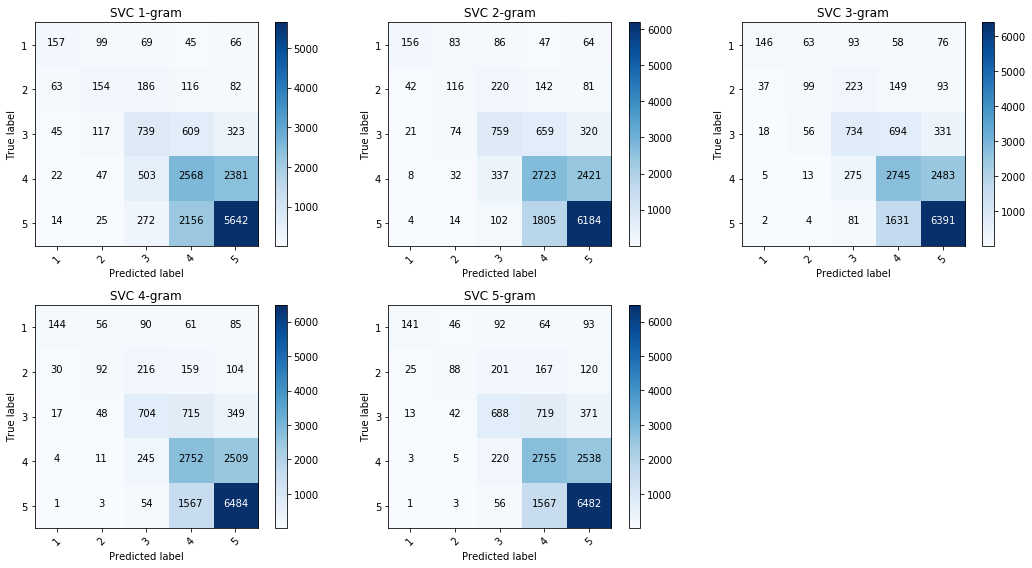

In [11]:
class_names = ['1', '2', '3', '4', '5']

plt.subplots(figsize=(15, 8))
plt.subplot(2, 3, 1)
plot_confusion_matrix(confusion_matrix(y_1gram, y_pred_1gram), classes=class_names, title='SVC 1-gram')
plt.subplot(2, 3, 2)
plot_confusion_matrix(confusion_matrix(y_2gram, y_pred_2gram), classes=class_names, title='SVC 2-gram')
plt.subplot(2, 3, 3)
plot_confusion_matrix(confusion_matrix(y_3gram, y_pred_3gram), classes=class_names, title='SVC 3-gram')
plt.subplot(2, 3, 4)
plot_confusion_matrix(confusion_matrix(y_4gram, y_pred_4gram), classes=class_names, title='SVC 4-gram')
plt.subplot(2, 3, 5)
plot_confusion_matrix(confusion_matrix(y_5gram, y_pred_5gram), classes=class_names, title='SVC 5-gram')

In [12]:
runtimes = [time_1gram, time_2gram, time_3gram, time_4gram, time_5gram]
accuracy = [scores_1gram.mean(), scores_2gram.mean(), scores_3gram.mean(), \
            scores_4gram.mean(), scores_5gram.mean()]
index    = ['1-gram', '2-gram', '3-gram', '4-gram', '5-gram']

results  = pd.DataFrame({'Runtime (s)': runtimes,
                        'Accuracy': accuracy},
                         index=index)
results

,Runtime (s),Accuracy
1-gram,25.01,0.561089
2-gram,68.95,0.602302
3-gram,113.80,0.613030
4-gram,166.32,0.616727
5-gram,196.36,0.615395


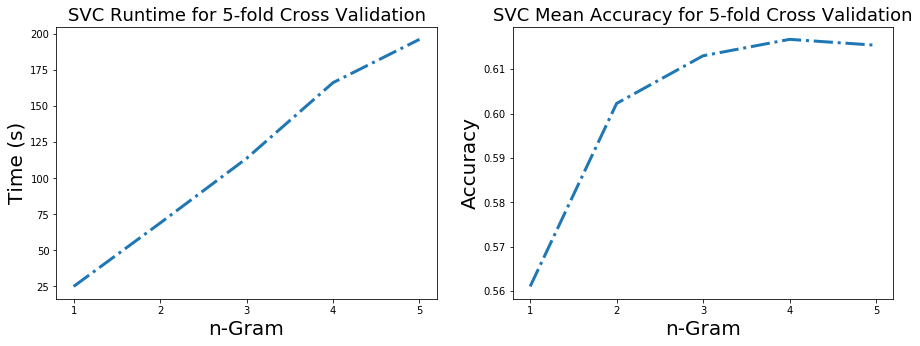

In [13]:
plt.subplots(figsize=(15, 5))

n_gram = [1, 2, 3, 4, 5]
plt.subplot(1, 2, 1)
_ = plt.plot(n_gram, runtimes, linestyle='-.', linewidth=3)
_ = plt.xticks(n_gram)
_ = plt.title('SVC Runtime for 5-fold Cross Validation', fontsize=18)
_ = plt.xlabel('n-Gram', fontsize=20)
_ = plt.ylabel('Time (s)', fontsize=20)

plt.subplot(1, 2, 2)
_ = plt.plot(n_gram, accuracy, linestyle='-.', linewidth=3)
_ = plt.xticks(n_gram)
_ = plt.title('SVC Mean Accuracy for 5-fold Cross Validation', fontsize=18)
_ = plt.xlabel('n-Gram', fontsize=20)
_ = plt.ylabel('Accuracy', fontsize=20)

plt.show()

## SVC Using TF-IDF Vectorization
### 1-Gram

In [14]:
time_1gram_tfidf, scores_1gram_tfidf, \
y_1gram_tfidf, y_pred_1gram_tfidf = svm_classifier(df_restaurant_reviews['review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 TfidfVectorizer, (1,1))

SVC Accuracy: [0.60793218 0.59969697 0.61212121 0.59836314 0.58095816]
Runtime: 2.57


### 2-Gram

In [15]:
time_2gram_tfidf, scores_2gram_tfidf, \
y_2gram_tfidf, y_pred_2gram_tfidf = svm_classifier(df_restaurant_reviews['review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 TfidfVectorizer, (1,2))

SVC Accuracy: [0.62034514 0.61787879 0.66787879 0.63685965 0.60733778]
Runtime: 6.73


### 3-Gram

In [16]:
time_3gram_tfidf, scores_3gram_tfidf, \
y_3gram_tfidf, y_pred_3gram_tfidf = svm_classifier(df_restaurant_reviews['review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 TfidfVectorizer, (1,3))

SVC Accuracy: [0.61429004 0.61121212 0.66636364 0.63776902 0.60521528]
Runtime: 12.3


### 4-Gram

In [17]:
time_4gram_tfidf, scores_4gram_tfidf, \
y_4gram_tfidf, y_pred_4gram_tfidf = svm_classifier(df_restaurant_reviews['review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 TfidfVectorizer, (1,4))

SVC Accuracy: [0.61035422 0.60757576 0.66757576 0.62988784 0.60612492]
Runtime: 23.01


### 5-Gram

In [18]:
time_5gram_tfidf, scores_5gram_tfidf, \
y_5gram_tfidf, y_pred_5gram_tfidf = svm_classifier(df_restaurant_reviews['review_text'], 
                                                                 df_restaurant_reviews['review_rating'], 
                                                                 TfidfVectorizer, (1,5))

SVC Accuracy: [0.59642749 0.59212121 0.66212121 0.62806911 0.59460279]
Runtime: 25.93


### Confusion Matrices for Model with respect to n-Gram

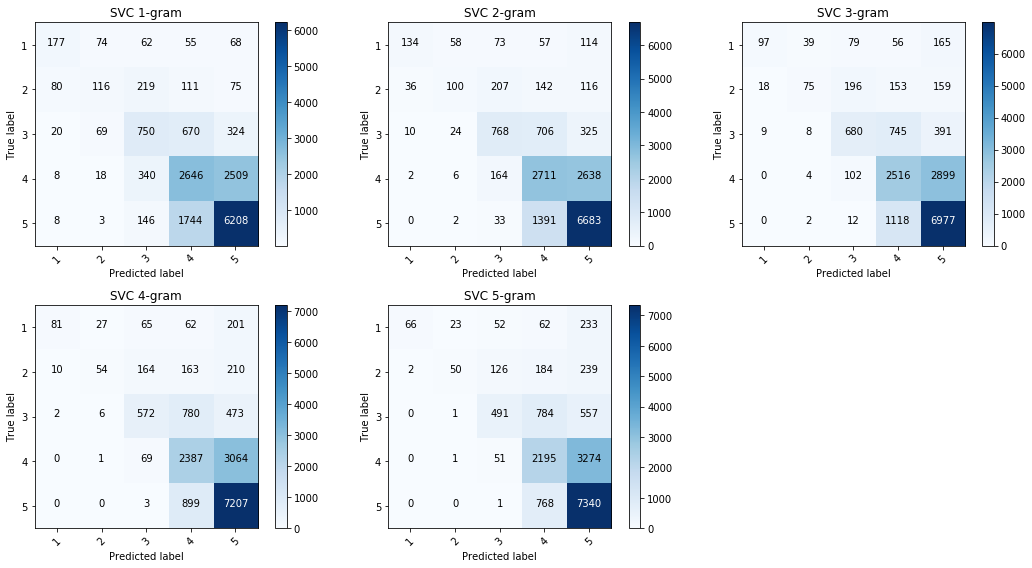

In [19]:
plt.subplots(figsize=(15, 8))
plt.subplot(2, 3, 1)
plot_confusion_matrix(confusion_matrix(y_1gram_tfidf, y_pred_1gram_tfidf), classes=class_names, title='SVC 1-gram')
plt.subplot(2, 3, 2)
plot_confusion_matrix(confusion_matrix(y_2gram_tfidf, y_pred_2gram_tfidf), classes=class_names, title='SVC 2-gram')
plt.subplot(2, 3, 3)
plot_confusion_matrix(confusion_matrix(y_3gram_tfidf, y_pred_3gram_tfidf), classes=class_names, title='SVC 3-gram')
plt.subplot(2, 3, 4)
plot_confusion_matrix(confusion_matrix(y_4gram_tfidf, y_pred_4gram_tfidf), classes=class_names, title='SVC 4-gram')
plt.subplot(2, 3, 5)
plot_confusion_matrix(confusion_matrix(y_5gram_tfidf, y_pred_5gram_tfidf), classes=class_names, title='SVC 5-gram')

In [20]:
runtimes_tfidf = [time_1gram_tfidf, time_2gram_tfidf, time_3gram_tfidf, time_4gram_tfidf, time_5gram_tfidf]
accuracy_tfidf = [scores_1gram_tfidf.mean(), scores_2gram_tfidf.mean(), scores_3gram_tfidf.mean(), \
                  scores_4gram_tfidf.mean(), scores_5gram_tfidf.mean()]
index_tfidf    = ['1-gram', '2-gram', '3-gram', '4-gram', '5-gram']

results_tfidf  = pd.DataFrame({'Runtime (s)': runtimes_tfidf,
                        'Accuracy': accuracy_tfidf},
                         index=index_tfidf)
results_tfidf

,Runtime (s),Accuracy
1-gram,2.57,0.599814
2-gram,6.73,0.630060
3-gram,12.30,0.626970
4-gram,23.01,0.624304
5-gram,25.93,0.614668


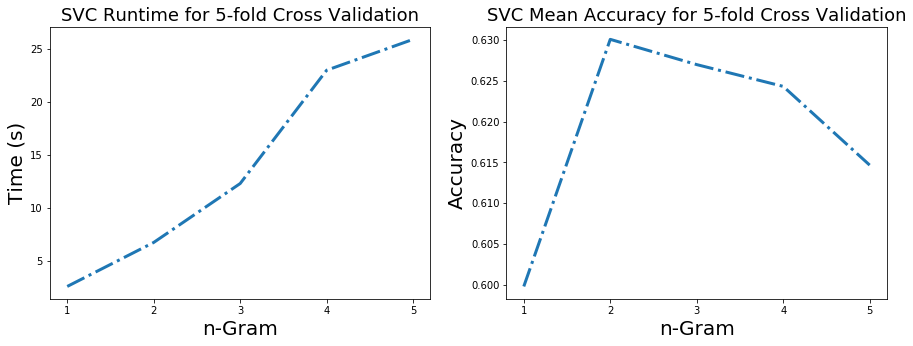

In [21]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
_ = plt.plot(n_gram, runtimes_tfidf, linestyle='-.', linewidth=3)
_ = plt.xticks(n_gram)
_ = plt.title('SVC Runtime for 5-fold Cross Validation', fontsize=18)
_ = plt.xlabel('n-Gram', fontsize=20)
_ = plt.ylabel('Time (s)', fontsize=20)

plt.subplot(1, 2, 2)
_ = plt.plot(n_gram, accuracy_tfidf, linestyle='-.', linewidth=3)
_ = plt.xticks(n_gram)
_ = plt.title('SVC Mean Accuracy for 5-fold Cross Validation', fontsize=18)
_ = plt.xlabel('n-Gram', fontsize=20)
_ = plt.ylabel('Accuracy', fontsize=20)

plt.show()

<p> The best performing SVC model has an accuracy of 63%
    This model uses the Tf-Idf vectorizer with bigram parameter input.
    We will use this model and apply it to our dataset.
</p>

In [22]:
def model_input_preprocessing(X, y, vect_func, n_gram):
    
    #1. Vectorize the restaurant reviews
    vect = vect_func(ngram_range=n_gram)
    review_x = vect.fit_transform(X)
    
    #2. Label encodes all possible restaurant ratings
    le = LabelEncoder()
    label = le.fit_transform(y)
    
    #3. One hot encodes restaurant ratings
    ohe = OneHotEncoder()
    review_y = ohe.fit_transform(label.reshape(-1,1)).toarray()
    review_y = np.argmax(review_y, axis=1)
     
    return review_x, review_y, vect, le

In [114]:
X, y, x_enc, y_enc = model_input_preprocessing(df_restaurant_reviews['review_text'], 
                                 df_restaurant_reviews['review_rating'], 
                                 TfidfVectorizer, (1,2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

model = LinearSVC()
start = time.time()
model.fit(X_train, y_train)
end   = time.time()
y_pred = model.predict(X_test)

print('The accuracy score of this model is {}'.format(accuracy_score(y_test, y_pred)))
print('Runtime {}s'.format(end-start))

The accuracy score of this model is 0.7033333333333334
Runtime 1.2992701530456543s


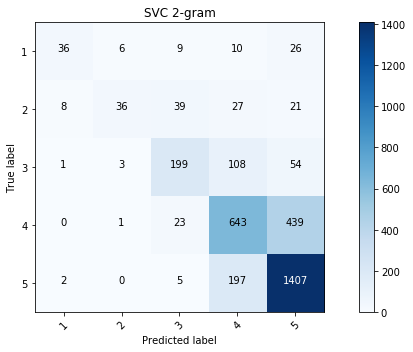

In [284]:
plt.subplots(figsize=(10, 5))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=class_names, title='SVC 2-gram')

## Word Cloud Visualization of Model

<p>Before Creating the word cloud, first we will reformat the    <br/>
   restaurant reviews test data such that all words from 5-star and <br/>
   1-star reviews will be consolidated into lists.</p>

### Data Processing Stage

In [115]:
#Multidimensional numpy array format to list
X_unvectorized   = x_enc.inverse_transform(X_test)
X_unvectorized   = [x.tolist() for x in X_unvectorized]

#Converting numpy array to list
y_unvectorized   = y_enc.inverse_transform(y_pred)
y_unvectorized   = y_unvectorized.tolist()

Xy_unvectorized  = list(zip(X_unvectorized, y_unvectorized))

In [116]:
#Filter out 5-star and 1-star reviews
filter_5star = list(filter(lambda x: x[1] == 5, Xy_unvectorized))
filter_1star = list(filter(lambda x: x[1] == 1, Xy_unvectorized))

In [117]:
#Store 5-star and 1-star reviews without rating
five_star_reviews, dummy = list(zip(*filter_5star))
one_star_reviews, dummy = list(zip(*filter_1star))

In [254]:
##Convert to lists of lists and flatten list
##And Remove Stopwords
from nltk.corpus import stopwords
sw = set(stopwords.words('english'))

five_star_flattened = list(five_star_reviews)
five_star_flattened = [val for sublist in five_star_reviews for val in sublist]
##Removing n-grams that contain stopwords
five_star_flattened = list(filter(lambda x: not bool(sw.intersection(set(x.split()))), five_star_flattened))

one_star_flattened = list(one_star_reviews)
one_star_flattened =  [val for sublist in one_star_reviews for val in sublist]
##Removing n-grams that contain stopwords
one_star_flattened = list(filter(lambda x: not bool(sw.intersection(set(x.split()))), one_star_flattened))

In [258]:
#Convert Lists into dictionaries with word as the key and frequency as value
import collections

five_star_dict = dict(collections.Counter(five_star_flattened).most_common())
one_star_dict = dict(collections.Counter(one_star_flattened).most_common())

### Word Cloud Visualizaiton Stage

In [96]:
from wordcloud import WordCloud
from PIL import Image

def transform_format(val):
    if val == 26:  #color yellow and blue contrast
        return 255
    else:
        return 0

In [279]:
wc_mask = np.array(Image.open('waiter.png'))
transformed_mask = np.ndarray((wc_mask.shape[0], wc_mask.shape[1]), np.int32)

for i in range(len(wc_mask)):
    transformed_mask[i] = list(map(transform_format, wc_mask[i]))

In [283]:
wc_mask

array([[26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       ...,
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26],
       [26, 26, 26, ..., 26, 26, 26]], dtype=uint8)

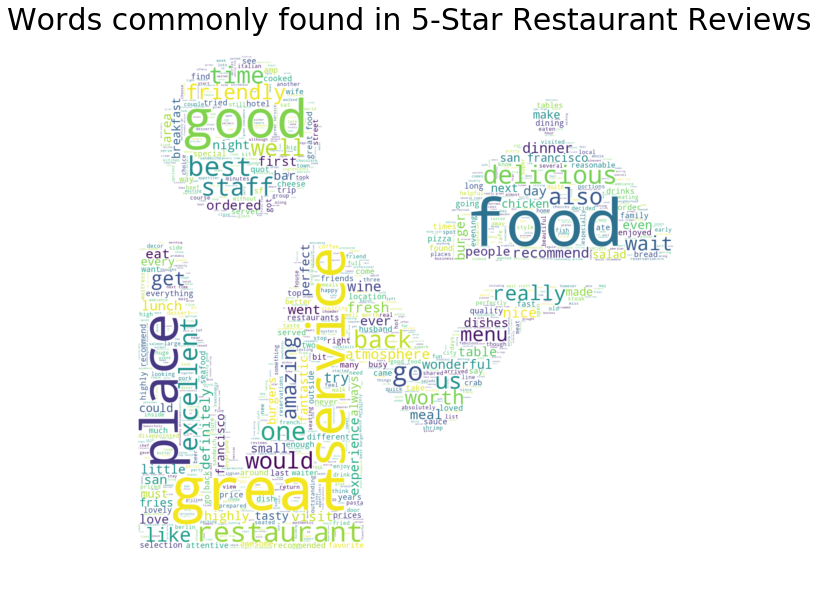

In [281]:
wc_5star = WordCloud(background_color='white', 
                     max_words=1000, mask=transformed_mask).generate_from_frequencies(five_star_dict)

plt.figure(figsize=(15, 10))
plt.imshow(wc_5star, interpolation='bilinear')
plt.axis('off')
plt.title('Words commonly found in 5-Star Restaurant Reviews', fontsize=30)
plt.show()

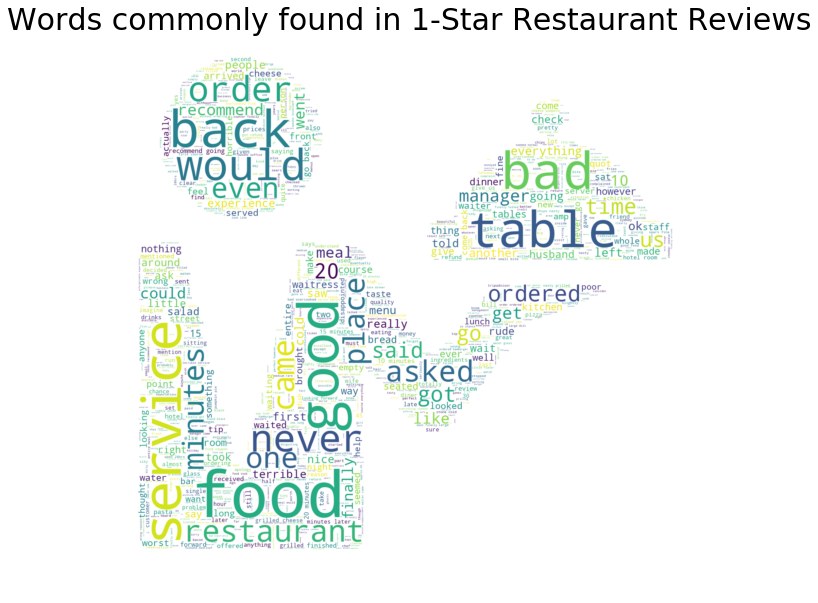

In [282]:
wc_1star = WordCloud(background_color='white', 
                     max_words=1000, mask=transformed_mask).generate_from_frequencies(one_star_dict)

plt.figure(figsize=(15, 10))
plt.imshow(wc_1star, interpolation='bilinear')
plt.axis('off')
plt.title('Words commonly found in 1-Star Restaurant Reviews', fontsize=30)
plt.show()